In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [5]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")
print(model_spec)

Lightning automatically upgraded your loaded checkpoint from v1.9.0 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt`


SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


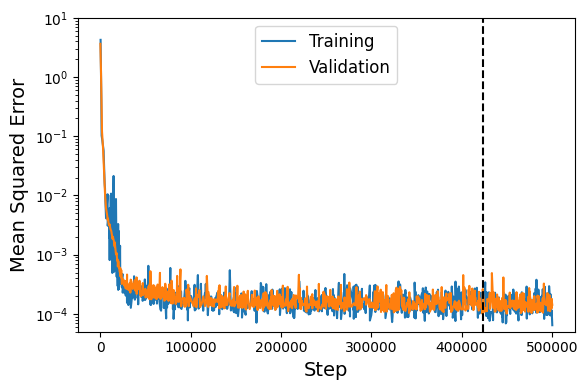

In [32]:
train_loss = np.loadtxt('production_models/version_large_training_set/version_large_training_set_train.csv', skiprows=1, delimiter=',')[:,1:]
valid_loss = np.loadtxt('production_models/version_large_training_set/version_large_training_set_valid.csv', skiprows=1, delimiter=',')[:,1:]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(train_loss[:,0], train_loss[:,1], label='Training')
ax.plot(valid_loss[:,0], valid_loss[:,1], label='Validation')
ax.vlines(valid_loss[np.argmin(valid_loss[:,1]),0], 5e-5, 10, color='k', linestyle='--')
ax.set_ylim(5e-5, 10)
ax.set_yscale('log')
ax.legend(loc='upper center', fontsize=12)
ax.set_xlabel('Step', fontsize=14)
ax.set_ylabel('Mean Squared Error', fontsize=14)
fig.tight_layout()
fig.savefig('figures/training_loss.pdf', bbox_inches='tight')

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


In [5]:
Y_test[:, -2:].max()

tensor(8.9999)

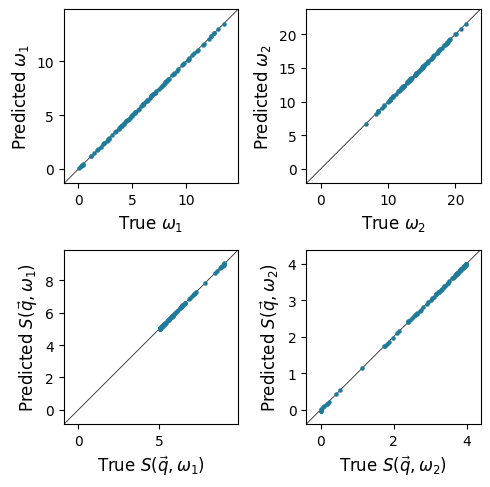

In [6]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [7]:
# from laplace.baselaplace import FullLaplace, DiagLaplace
# from laplace.curvature.backpack import BackPackGGN

# from laplace import Laplace, marglik_training

In [8]:
print(model_spec)

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [9]:
# la = Laplace(model_spec.fc_net.to(device), 
#              'regression', 
#              subset_of_weights='all', 
#              hessian_structure='kron',)
# la.fit(train_dataloader)

In [10]:
# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in tqdm(range(10)):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward()
#     hyper_optimizer.step()

In [11]:
gamma = 0.1
# times = np.arange(0,3,0.01)
times = np.linspace(0, 3, 121)
settings = (times, )
n_particles = 101
parameters = (
    np.random.uniform(-3.0, -1.0, n_particles),
    np.random.uniform(-1.0,-0.0, n_particles),
    np.random.uniform( 0.0, 1.0, n_particles),
    np.random.uniform( 0.0, 10.0, n_particles),
    np.random.uniform( 0.1, 2.0, n_particles)
    )

In [12]:
%load_ext autoreload
%autoreload 2
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt
from src.utils_model import tensor2array, array2tensor
import optbayesexpt as obe
from src.utils_convolution import get_I_conv, interp_nb

In [13]:
from src.utils_general import prepare_sample

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [14]:
target_idx = 40

pulse_width = 0.1
noise_level = 1
N_steps_bayes = 70
normalize_to_value = 100

In [15]:
from src.CrI3.prepare import prepare_CrI3_sample

# param_true, func_I_conv, func_I_noconv = prepare_CrI3_sample(times, pulse_width=0.1, mode='lorentzian', E_cutoff=5.0,
#                     amp_increase_factor=1.0, elas_bkg_amp_factor=0.5, elas_bkg_wid=0.5)

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):


[-1.78435064 -0.76653415  0.1         3.02493167  0.5       ]


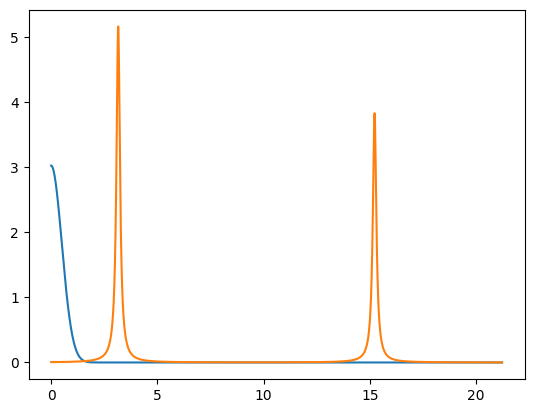

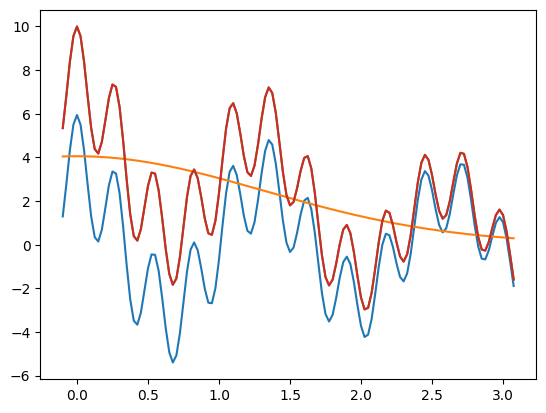

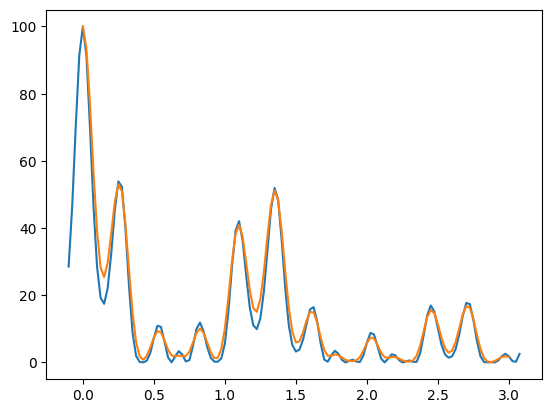

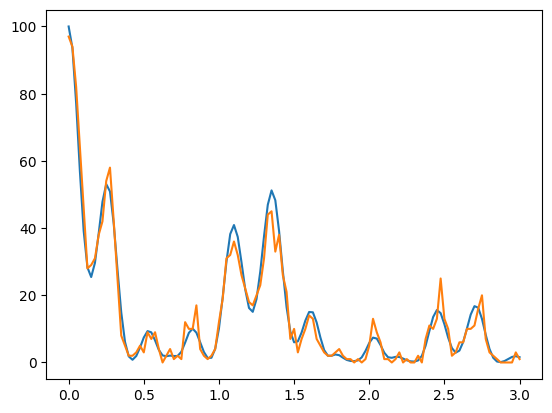

In [16]:
param_true, func_I_conv, func_I_noconv = \
    prepare_sample(X_test[target_idx], Y_test[target_idx], gamma, times, 
                   pulse_width=pulse_width, visualize=True, normalize_to_value=normalize_to_value,
                   elas_amp_factor=0.5850576985324748, elas_wid=0.5, elas_amp_abs_max=1000.)

# param_true, func_I_conv, func_I_noconv = \
#     prepare_CrI3_sample(times, amp_increase_factor=1.05, pulse_width=pulse_width)
print(param_true)
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level, noise_mode='poisson')
obe_sim_noisefree = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0)

plt.figure()
plt.plot(times, obe_sim_noisefree.simdata((times,)))
plt.plot(times, obe_sim.simdata((times,)))
# plt.figure()
# plt.plot(times, np.log(obe_sim.simdata((times,))))
# plt.plot(times, np.log(obe_sim_noisefree.simdata((times,))))

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from src.bayes import BayesianInference
bayes = BayesianInference(
    model_spec, settings, parameters, noise_level=noise_level,
    pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
    cost_repulse_height=10.0, cost_repulse_width=0.25,
    parameter_mins=(-3,-1,0,0,0.1), parameter_maxs=(-1,0,1,15,2), 
    selection_method='unique_optimal', utility_method='variance_full',
    model_uncertainty=False, device=device)
# bayes.obe_model.set_selection_method('unique_optimal')
# bayes.obe_model.set_selection_method('sequential')

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),


In [19]:
# bayes.obe_model.set_selection_method('sequential')
particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_w_GD(
    40, obe_sim, N_GD=100, lr=0.01, ret_particles=True, verbose=True,
    gd_seperation=14, error_criterion=10)
# particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(
#     100, obe_sim, ret_particles=True, verbose=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

using the unique_optimal setting


Running OptBayesExpt:  22%|██▎       | 9/40 [00:05<00:07,  3.89it/s]c:\Users\zhant\.conda\envs\sqt\lib\site-packages\optbayesexpt\particlepdf.py:199: RuntimeWarning: Degrees of freedom <= 0 for slice
  raw_covariance = np.cov(self.particles, aweights=self.particle_weights)
c:\Users\zhant\.conda\envs\sqt\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
Running OptBayesExpt:  32%|███▎      | 13/40 [00:05<00:04,  6.53it/s]

running GD at step 14, current error 41.909866717863785
J change:  tensor(0.0100, device='cuda:0')
D change:  tensor(0.0100, device='cuda:0')


c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_gd.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pulse_width = torch.tensor(pulse_width).to(y).clone().detach()


J change:  tensor(0.0093, device='cuda:0')
D change:  tensor(0.0093, device='cuda:0')
J change:  tensor(0.0090, device='cuda:0')
D change:  tensor(0.0089, device='cuda:0')
J change:  tensor(0.0087, device='cuda:0')
D change:  tensor(0.0083, device='cuda:0')
J change:  tensor(0.0084, device='cuda:0')
D change:  tensor(0.0077, device='cuda:0')
J change:  tensor(0.0081, device='cuda:0')
D change:  tensor(0.0072, device='cuda:0')
J change:  tensor(0.0078, device='cuda:0')
D change:  tensor(0.0068, device='cuda:0')
J change:  tensor(0.0075, device='cuda:0')
D change:  tensor(0.0063, device='cuda:0')
J change:  tensor(0.0072, device='cuda:0')
D change:  tensor(0.0057, device='cuda:0')
J change:  tensor(0.0068, device='cuda:0')
D change:  tensor(0.0050, device='cuda:0')
J change:  tensor(0.0065, device='cuda:0')
D change:  tensor(0.0046, device='cuda:0')
J change:  tensor(0.0061, device='cuda:0')
D change:  tensor(0.0043, device='cuda:0')
J change:  tensor(0.0059, device='cuda:0')
D change:  

Running OptBayesExpt:  40%|████      | 16/40 [00:10<00:15,  1.55it/s]

J change:  tensor(0.0004, device='cuda:0')
D change:  tensor(0.0004, device='cuda:0')
J change:  tensor(0.0004, device='cuda:0')
D change:  tensor(0.0004, device='cuda:0')
J change:  tensor(0.0005, device='cuda:0')
D change:  tensor(0.0003, device='cuda:0')
J change:  tensor(0.0005, device='cuda:0')
D change:  tensor(0.0003, device='cuda:0')


Running OptBayesExpt:  70%|███████   | 28/40 [00:11<00:02,  5.84it/s]

running GD at step 28, current error 18.711463158209277
J change:  tensor(0.0100, device='cuda:0')
D change:  tensor(0.0100, device='cuda:0')
J change:  tensor(0.0091, device='cuda:0')
D change:  tensor(0.0091, device='cuda:0')
J change:  tensor(0.0089, device='cuda:0')
D change:  tensor(0.0086, device='cuda:0')
J change:  tensor(0.0085, device='cuda:0')
D change:  tensor(0.0079, device='cuda:0')
J change:  tensor(0.0082, device='cuda:0')
D change:  tensor(0.0074, device='cuda:0')
J change:  tensor(0.0080, device='cuda:0')
D change:  tensor(0.0071, device='cuda:0')
J change:  tensor(0.0078, device='cuda:0')
D change:  tensor(0.0067, device='cuda:0')
J change:  tensor(0.0076, device='cuda:0')
D change:  tensor(0.0063, device='cuda:0')
J change:  tensor(0.0074, device='cuda:0')
D change:  tensor(0.0059, device='cuda:0')
J change:  tensor(0.0073, device='cuda:0')
D change:  tensor(0.0054, device='cuda:0')
J change:  tensor(0.0070, device='cuda:0')
D change:  tensor(0.0048, device='cuda:0'

Running OptBayesExpt: 100%|██████████| 40/40 [00:13<00:00,  3.04it/s]

[-1.79755695 -0.77280808  0.20551593  2.70429037  0.55193764] [0.00372698 0.00184306 0.01513131 0.15086056 0.01475617]


In [20]:
# bayes.obe_model.particles[0] = -2 * np.ones_like(bayes.obe_model.particles[0])
# bayes.obe_model.particles[2] = 0.3 * np.ones_like(bayes.obe_model.particles[2])

In [36]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

idx_plot = -1
# utility_plot = bayes.utility_list[idx_plot]
# utility_plot = 20 * utility_plot / utility_plot.max()

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])
# _, measurements_predicted = bayes.predict_all_settings(param_true)
measurements_predicted *= normalize_to_value / measurements_predicted[0]

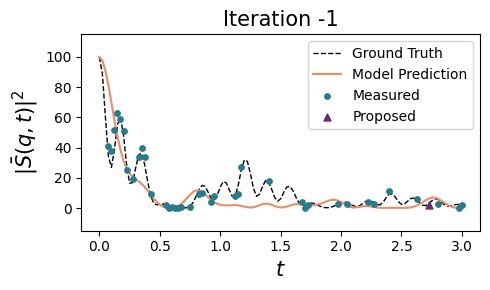

In [37]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
# ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=15, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=25, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+15])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

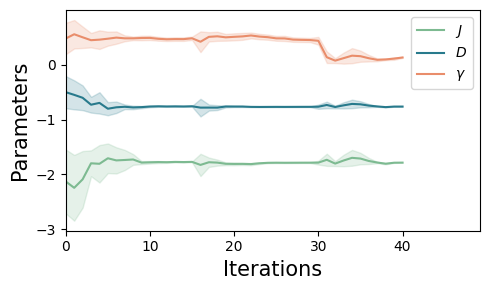

In [23]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0], palette_flare[-3], palette_flare[-1]]

label_lst = ["$J$", "$D$", "$\gamma$", "$a$", "$\sigma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(5):
    
    if i <= 2:
        ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
        # ax.hlines(param_true[i], -100, 100*maxiter, linestyles='--', color='gray')
        ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')

In [97]:
errors[40]

88.96653218238048

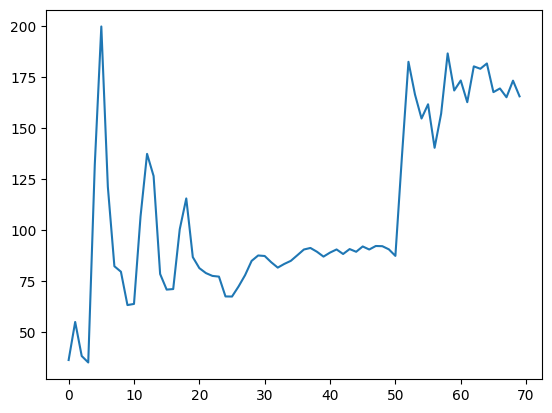

In [98]:
plt.plot(errors)

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter)[:idx_plot-1], param_mean[:idx_plot-1,i]-param_std[:idx_plot-1,i], param_mean[:idx_plot-1,i]+param_std[:idx_plot-1,i], color=colors[i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax[0].plot(np.arange(maxiter)[:idx_plot-1], param_mean[:idx_plot-1,i], color=colors[i], label=label_lst[i])
ax[0].set_xlim([-0.*idx_plot, 1.2*idx_plot])
ax[0].legend(fontsize=10)
ax[0].set_xlabel("Iterations", fontsize=15)
ax[0].set_ylabel("Parameters", fontsize=15)

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
ax[1].fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax[1].scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=30, color=palette_crest[-3], zorder=10)
ax[1].scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=50, color=palette_flare[-1], zorder=20, marker='^')
ax[1].legend(fontsize=10)
ax[1].set_xlabel('$t$', fontsize=15)
ax[1].set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)

fig.tight_layout()
fig.savefig(f'figs/paper/exp_steering_sample{idx}_iter{idx_plot}.pdf')

In [ ]:
plt.plot(bayes.obe_model.cost_estimate())
# plt.plot(bayes.utility_list[-1])

In [ ]:
gd_loss_hist, gd_param_hist = bayes.run_gradient_desc_on_current_measurements(
    200, lr=0.001, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
def normalize(arr, arr_min, arr_max):
    delta_arr = (arr.max() - arr.min())
    if delta_arr > 0:
        arr_new = (arr - arr.min()) / delta_arr
        arr_new = arr_new * (arr_max - arr_min) + arr_min
        return arr_new
    else:
        return np.ones_like(arr)

In [ ]:
cmap = seaborn.color_palette(palette='flare', as_cmap=True)
norm = Normalize(0, len(particles_hist)-1)

In [ ]:
def plot_scatter_series(data, special_point=None, labels=None, special_point_label=None, save_name=None):
    data_size, num_points = data.shape[0], data.shape[-1]
    norm = Normalize(0, data_size-1)
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    if labels is not None:
        assert len(labels) == data_size
    
    for i in range(data_size):
        colors = np.array(cmap(norm(i)))[np.newaxis,:].repeat(num_points, axis=0)
        # colors[:,-1] = normalize(p_weights_hist[i], 0.25, 0.5)
        # colors[:,-1] = 0.25
        ax.scatter(data[i,0], data[i,1], color=colors, s=10, label=None if labels is None else labels[i])
    if special_point is not None:
        ax.scatter(special_point[0], special_point[1], color="#70B6A1", marker='*', s=30)
    if labels is not None:
        ax.legend(ncol = 2, fontsize=10)
    ax.set_xlabel("$J$", fontsize=15)
    ax.set_ylabel("$D$", fontsize=15)
    if save_name is not None:
        fig.savefig(save_name, dpi=300, bbox_inches='tight')

In [ ]:
# indices = np.linspace(0, len(particles_hist)-1, 5).astype('int')
indices = [0, 5, 6, 49]
plot_scatter_series(particles_hist[indices], labels=[f'Iteration {i}' for i in indices], save_name=f'figs/paper/baysian_population_evolution_sample{idx}.pdf')

In [ ]:
gd_param_hist_for_plot = torch.cat((gd_param_hist['J'][:,None], gd_param_hist['D'][:,None]), dim=1).numpy()
indices = np.linspace(0, len(gd_param_hist_for_plot)-1, 5).astype('int')
plot_scatter_series(gd_param_hist_for_plot[indices], save_name='figs/paper/gd_first_round.pdf')

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
bayes.update_OptBayesExpt_particles()
print(bayes.obe_model.mean(), bayes.obe_model.std())
particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(50, obe_sim, ret_particles=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

In [ ]:
indices = np.linspace(0, len(particles_hist)-1, 10).astype('int')
plot_scatter_series(particles_hist[indices], special_point=x_val,save_name='figs/paper/baysian_second_round.pdf')

In [ ]:
_, _ = bayes.run_gradient_desc_on_current_measurements(100, batch_size=bayes.obe_model.n_particles, init_bayes_guess=False)

In [ ]:
ranges_J = [bayes.forward_model.J.min().item()-0.25, bayes.forward_model.J.max().item()+0.25]
ranges_D = [bayes.forward_model.D.min().item()-0.25, bayes.forward_model.D.max().item()+0.25]

fig, ax = plt.subplots(1,1)
ax.hist2d(
    bayes.forward_model.J.squeeze().detach().cpu().numpy(), 
    bayes.forward_model.D.squeeze().detach().cpu().numpy(), 
    bins=[int((ranges_J[1]-ranges_J[0])//0.05),int((ranges_D[1]-ranges_D[0])//0.05)], range=[ranges_J, ranges_D],
    cmap=plt.colormaps['bone']
)
ax.vlines(x_val[0], -10, 10, colors='white', linestyle='--')
ax.hlines(x_val[1], -10, 10, colors='white', linestyle='--')
ax.set_xlim(ranges_J)
ax.set_xlabel("$J$", fontsize=18)
ax.set_ylim(ranges_D)
ax.set_ylabel("$D$", fontsize=18)
ax.set_aspect('equal')
fig.tight_layout()

In [ ]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings()

In [ ]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(2,1,figsize=(6,6))
for i in range(param_mean.shape[1]):
    ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
    ax[0].hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')
    ax[0].plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax[0].set_xlim([-0.*maxiter, 1.2*maxiter])
ax[0].legend()
ax[0].set_xlabel("Iterations", fontsize=12)
ax[0].set_ylabel("Parameters", fontsize=12)

ax[1].plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax[1].plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=1)
ax[1].scatter(measured_settings.squeeze(), measured_observables.squeeze(), label="Measurement", s=12, color=palette_crest[-3], zorder=10)
ax[1].legend(fontsize=9)
ax[1].set_xlabel('$t$', fontsize=12)
ax[1].set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=12)

fig.tight_layout()
fig.savefig('figs/paper/exp_steering.pdf')

In [ ]:
from matplotlib.animation import FuncAnimation

fig = plt.Figure(figsize=(6,6)) # this creates a Figure() instance
# ax = fig.add_subplot()
gs = fig.add_gridspec(2,1)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

ax0.set_xlim([-0.*maxiter, 1.2*maxiter])
ax0.set_ylim([-3.1,1.0])
ax0.set_xlabel("Iterations", fontsize=18)
ax0.set_ylabel("Parameters", fontsize=18)
for i in range(param_mean.shape[1]):
    # ax[0].fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], alpha=0.2)
    ax0.hlines(true_pars[i], -100, 100*maxiter, linestyles='--', color='gray')

ax1.set_xlim([0, 1.1*times.max()])
ax1.plot(times, true_S, color='k', label="Ground Truth")
ax1.set_xlabel("$t$", fontsize=18)
ax1.set_ylabel("$S(q,t)$", fontsize=18)
line_pred, = ax1.plot([], [], lw=2)
sc = ax1.scatter([], [], color='C2', s=12)

line_J, = ax0.plot([], [], lw=2)
line_D, = ax0.plot([], [], lw=2)
line_gamma, = ax0.plot([], [], lw=2)
fig.tight_layout()

def init():
    i=1
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    line_J.set_label(label_lst[0])
    line_D.set_label(label_lst[1])
    line_gamma.set_label(label_lst[2])
    ax0.legend(loc='center right')
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred
def animate(i):
    line_J.set_data(np.arange(i), param_mean[:i,0])
    line_D.set_data(np.arange(i), param_mean[:i,1])
    line_gamma.set_data(np.arange(i), param_mean[:i,2])
    sc.set_offsets(np.concatenate((measured_settings.squeeze()[:i,None], measured_observables.squeeze()[:i,None]),axis=1))
    line_pred.set_data(times, bayes.model_predictions_on_obe_mean[i])
    sc.set_zorder(10)
    return line_J, line_D, line_gamma, sc, line_pred

anim = FuncAnimation(
    fig, animate, init_func=init,
    frames=maxiter, interval=100, blit=True)

anim.save(f'out/gifs/sequential_J={true_pars[0]:.3f}_D={true_pars[1]:.3f}_gamma={true_pars[2]:.3f}.gif', dpi=300)